In [0]:
import pandas as pd 
import numpy as np 
import pickle 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import seaborn as sns 

from scipy import stats 
from pylab import rcParams

from sklearn.model_selection import train_test_split 
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline 
sns.set(style = 'darkgrid', palette = 'pastel', font_scale = 1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42 
LABELS = ['Normal', 'Fraud']

In [0]:
data = pd.read_csv('drive/app/creditcard.csv')

In [5]:
data.shape

(284807, 31)

In [6]:
data.isnull().values.any()

False

In [0]:
count_classes = pd.value_counts(data['Class'], sort = True)

Text(0,0.5,'Frequency')

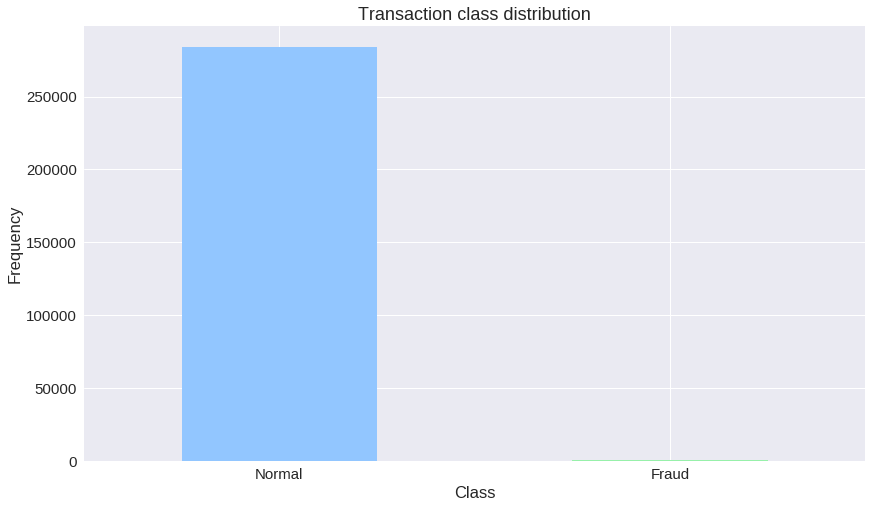

In [13]:
count_classes.plot(kind = 'bar', rot = 0)
plt.title('Transaction class distribution')
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [14]:
frauds = data[data.Class == 1]
normal = data[data.Class == 0]

print('fraudulent transactions: {}'.format(frauds.shape))
print('normal transaxtions : {}'.format(normal.shape))

fraudulent transactions: (492, 31)
normal transaxtions : (284315, 31)


In [15]:
print('Fraudulent transactions VS Normal transactions MONEY AMOUNT comparison')

print('FRAUDS:')
print(frauds.Amount.describe())

print('NORMAL:')
print(normal.Amount.describe())

Fraudulent transactions VS Normal transactions MONEY AMOUNT comparison
FRAUDS:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
NORMAL:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


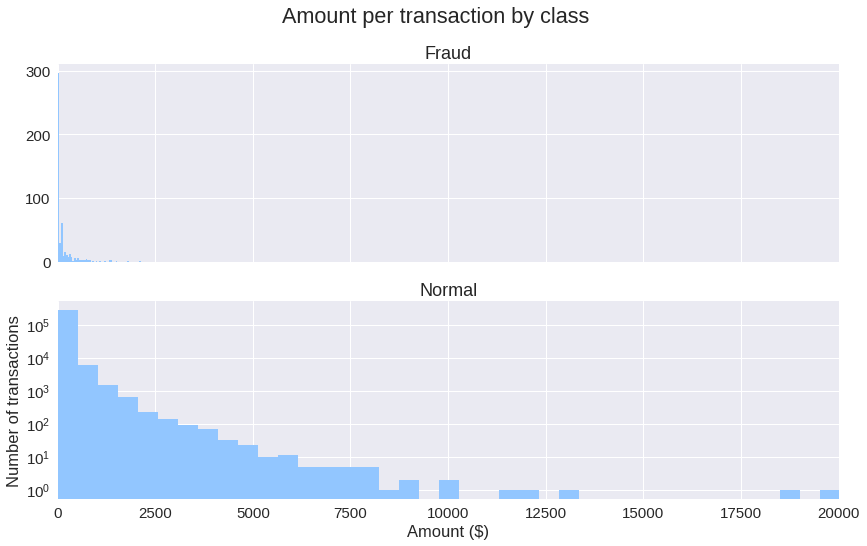

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

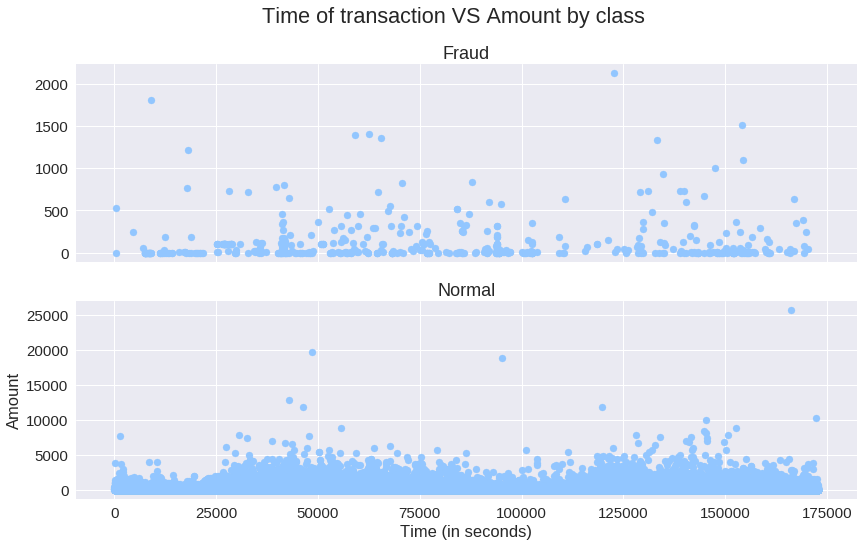

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Time of transaction VS Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler 
data = data.drop(['Time'], axis = 1)
# remove the mean and scale values to unit variance
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1)) 

In [0]:
X_train, X_test = train_test_split(data, test_size = 0.2, random_state = RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis = 1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis = 1)

In [20]:
X_train = X_train.values
X_test = X_test.values 

print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))

X_train: (227451, 29)
X_test: (56962, 29)


BUILDING THE MODEL

Autoencoder uses 4 fully connected layers: 
- 14 neurons (encoder)
- 7 neurons (encoder)
- 7 neurons (decoder)
- 29 neurons (decoder)

Usage of L1 regularization. 

TRAINING THE MODEL 

- number of epochs = 100
-  batch_size = 32 

Save best performing model to a file -> Usage of Keras' ModelCheckpoint. 

Training progress will be exported in a format that TensorBoard understands. 

In [21]:
input_dim = X_train.shape[1] # 29
encoding_dim = 14 

input_layer = Input(shape = (input_dim, ))
encoder = Dense(encoding_dim, activation = 'tanh',
               activity_regularizer = regularizers.l1(10e-5))(input_layer)
print(encoder)

encoder = Dense(int(encoding_dim/2), activation = 'relu')(encoder)
print(encoder)

decoder = Dense(int(encoding_dim/2), activation = 'tanh')(encoder)
print(decoder)

decoder = Dense(input_dim, activation = 'relu')(decoder)
print(decoder)

autoencoder = Model(inputs = input_layer, outputs = decoder)
print(autoencoder)

Tensor("dense_1/Tanh:0", shape=(?, 14), dtype=float32)
Tensor("dense_2/Relu:0", shape=(?, 7), dtype=float32)
Tensor("dense_3/Tanh:0", shape=(?, 7), dtype=float32)
Tensor("dense_4/Relu:0", shape=(?, 29), dtype=float32)


In [0]:
nb_epochs = 100
batch_size = 32 

In [0]:
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', 
                   metrics = ['accuracy'])


In [0]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                              verbose = 0,
                              save_best_only = True)

In [0]:
tensorboard = TensorBoard(log_dir = './logs',
                         histogram_freq = 0, 
                         write_graph = True,
                         write_images = True)

In [0]:
history = autoencoder.fit(X_train, X_train, epochs = nb_epochs, 
                         batch_size = batch_size,
                         shuffle = True,
                         validation_data = (X_test, X_test),
                         verbose = 0,
                         callbacks = [checkpointer, tensorboard]).history

In [0]:
pickle.dump(history, open('drive/app/history.p', 'wb'))

In [0]:
history = pickle.load(open('drive/app/history.p','rb'))

In [0]:
# sanity check the saved model works 
autoencoder = load_model('model.h5')

MODEL EVALUATION

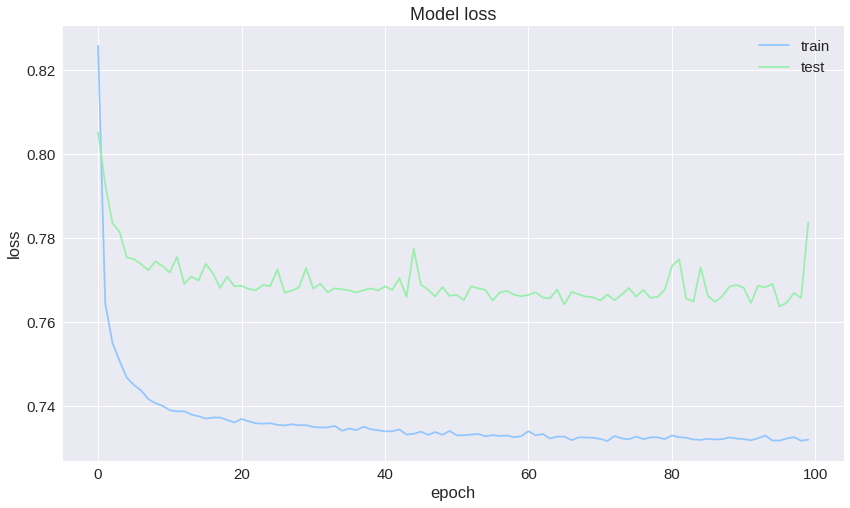

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')

In [0]:
predictions = autoencoder.predict(X_test)

In [30]:
mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error':mse, 'true_class':y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,1.107231,0.001720
std,3.817226,0.041443
min,0.169645,0.000000
25%,0.434984,0.000000
50%,0.663389,0.000000
75%,1.001665,0.000000
max,263.672925,1.000000


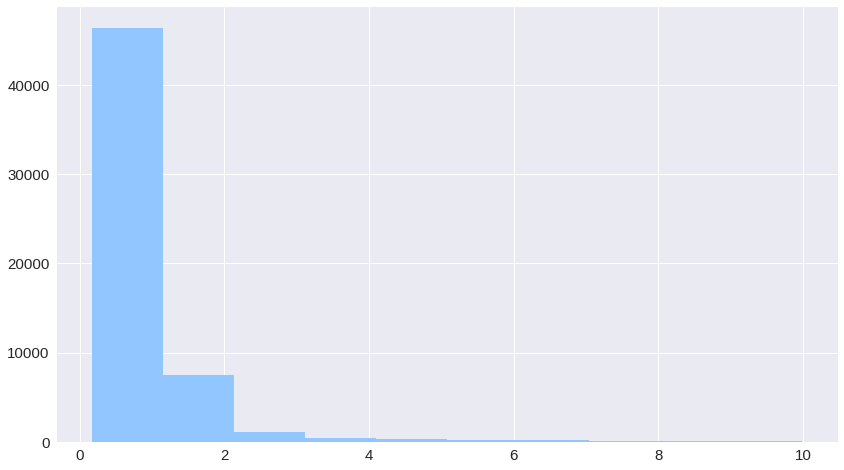

In [31]:
fig = plt.figure() 
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins = 10)
                                                            

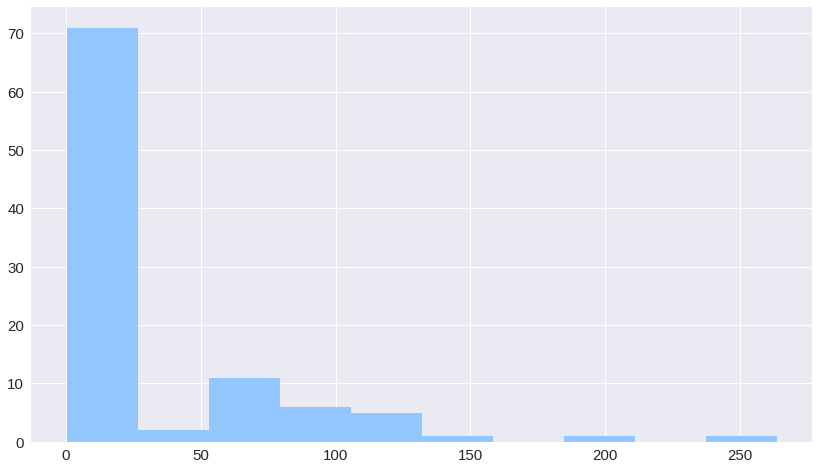

In [32]:
fig = plt.figure() 
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins = 10)

In [0]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support

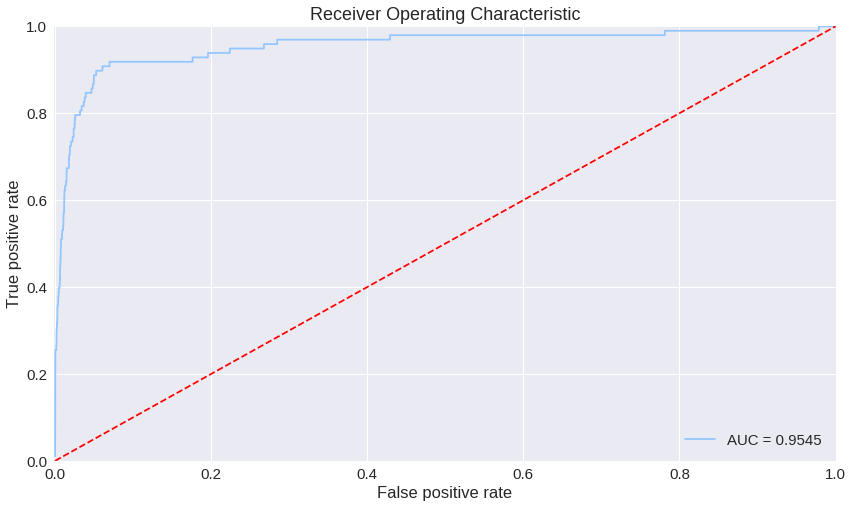

In [34]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.4f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

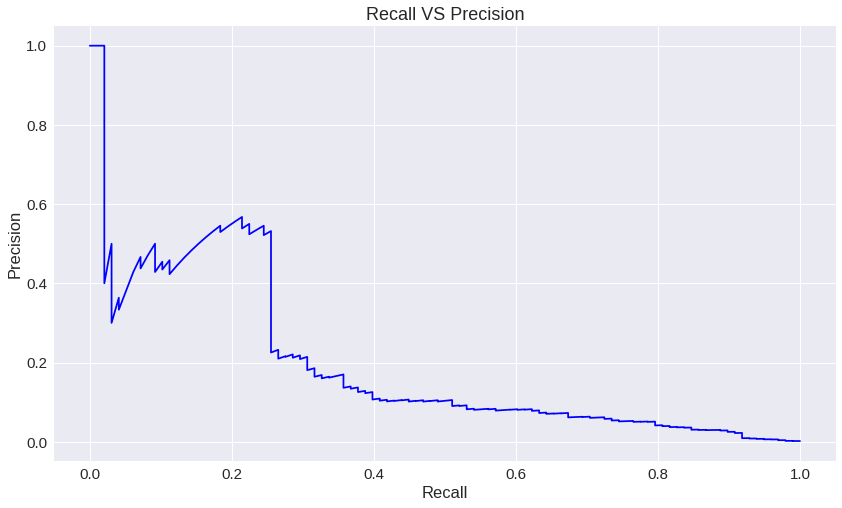

In [36]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label = 'Precision-Recall curve')
plt.title('Recall VS Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

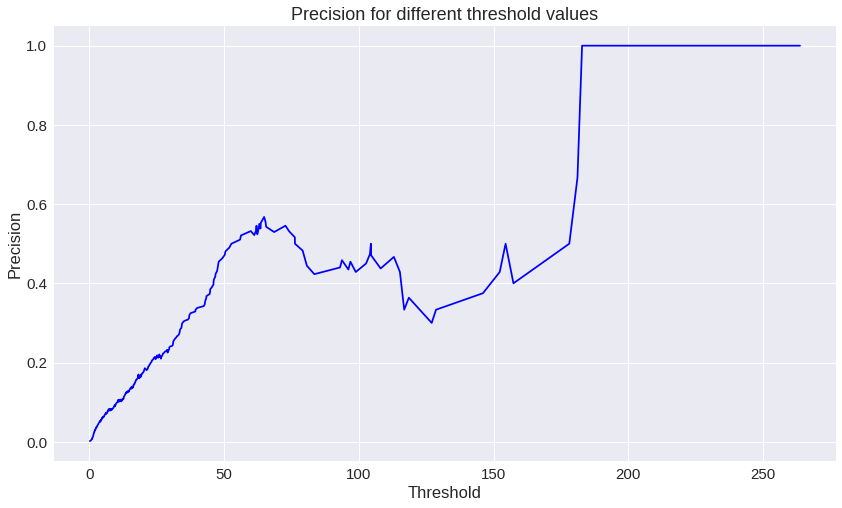

In [38]:
plt.plot(th, precision[1:], 'b', label = 'Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

[]

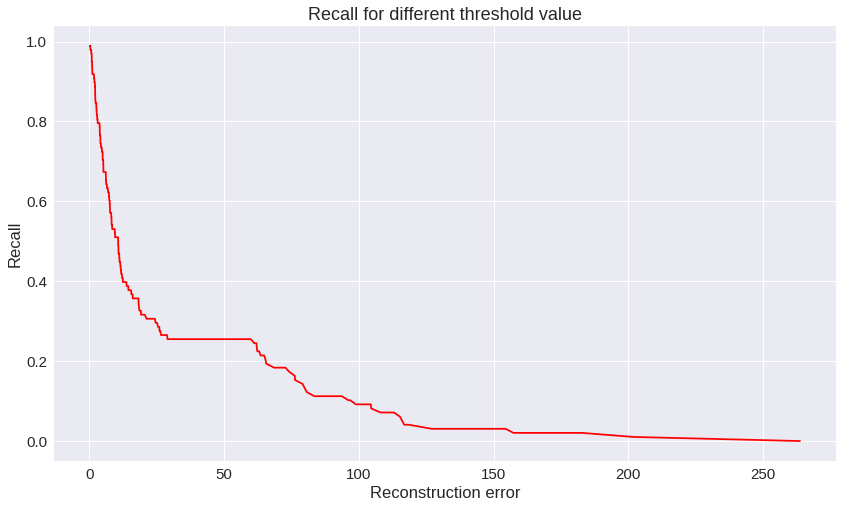

In [40]:
plt.plot(th, recall[1:], 'r', label = 'Threshold-Recall curve')
plt.title('Recall for different threshold value')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.plot()

In [0]:
threshold = 2.9

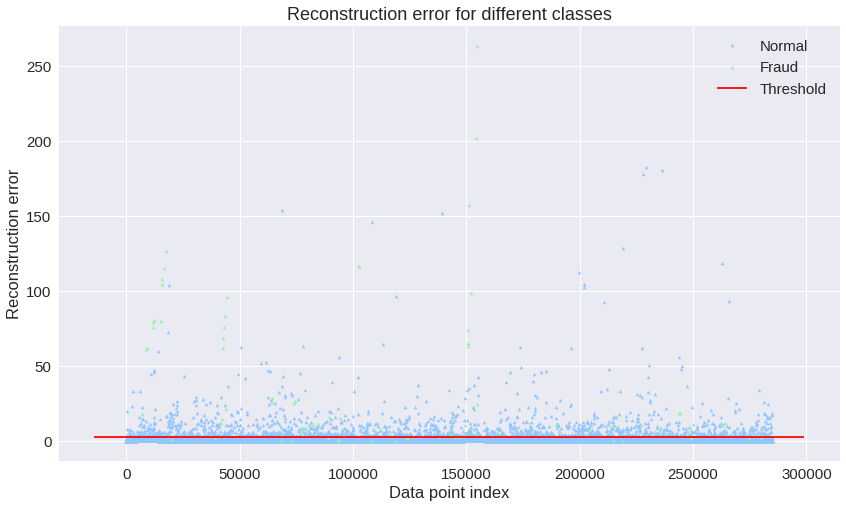

In [61]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups: 
  ax.plot(group.index, group.reconstruction_error, marker = '^', ms = 3.5, linestyle = '', label = 'Fraud' if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors = 'r', zorder = 100, label = 'Threshold')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

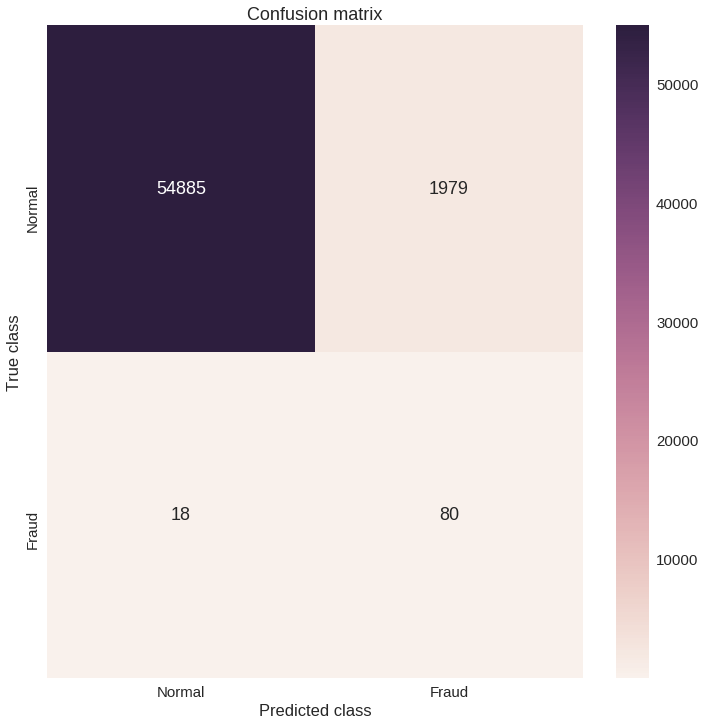

In [62]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize = (12,12))
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = 'd')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()